# 1. IMPORT DEPENDENCES

In [3]:
pip install np-utils

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip show tensorflow

Name: tensorflow
Version: 2.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /workspaces/project/env/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 15.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16, DenseNet201, EfficientNetB4
from tensorflow.keras.applications import resnet, vgg16 , densenet, efficientnet
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import PIL
import os
import cv2



In [9]:
tf.__version__

'2.14.0'

# 2. GET THE DATA READY FOR TRAINING

The dataset for Chest CT Scan Images are taken from kaggle.
#### Dataset [Link](https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images)

In [12]:
import os
os.chdir('../')

In [13]:
path = "artifacts/data_ingestion/Chest-CT-Scan-data/Data/train"
for files in os.listdir(path):
    print(os.path.join(path,files))

artifacts/data_ingestion/Chest-CT-Scan-data/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
artifacts/data_ingestion/Chest-CT-Scan-data/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
artifacts/data_ingestion/Chest-CT-Scan-data/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
artifacts/data_ingestion/Chest-CT-Scan-data/Data/train/normal


Then we set the path for this data.

In [14]:
train_path = "artifacts/data_ingestion/Chest-CT-Scan-data/Data/train"
valid_path = "artifacts/data_ingestion/Chest-CT-Scan-data/Data/valid"
test_path = "artifacts/data_ingestion/Chest-CT-Scan-data/Data/test"

In [17]:
image_paths = ['artifacts/data_ingestion/Chest-CT-Scan-data/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa',
'artifacts/data_ingestion/Chest-CT-Scan-data/Data/train/normal',
'artifacts/data_ingestion/Chest-CT-Scan-data/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
'artifacts/data_ingestion/Chest-CT-Scan-data/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']

def load_images(image_paths=image_paths, n=36, target_size=(100, 100)):
    images = []
    for image_path in image_paths:
        images_ = []
        for path in os.listdir(image_path)[:int(n/len(image_paths))]:
            img = cv2.imread(os.path.join(image_path, path))
            if img is not None:
                img = cv2.resize(img, target_size)
                images_.append(img)
        images.append(images_)
    return np.asarray(images)


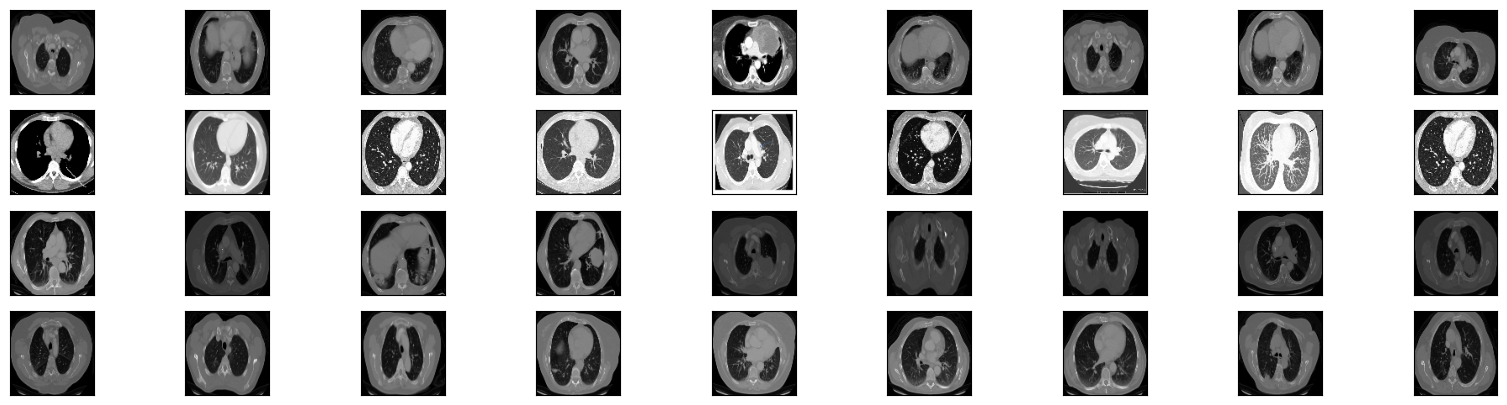

In [18]:
sample = load_images()
fig = plt.figure(figsize=(20, 5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4, 9, m+l, xticks=[], yticks=[])
        ax.imshow(cv2.cvtColor(sample[i, m], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
        shapes.append(sample[i, m].shape)
    l += 9

plt.show()

In [19]:
np.array(shapes).mean(axis=0)


array([100., 100.,   3.])

# 3. IMAGE PREPROCESSING

* When using Gradient Descent, We should ensure that all Features have a similar scale, otherwise, it will take much longer to converge.

In [20]:
image_shape = (305,430,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (305,430),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


# 4. BUILDING THE MODEL ARCHITECTURE

In [89]:
base_hidden_units = 8
weight_decay = 1e-3
model = Sequential([

    Conv2D(filters = 8 , kernel_size = 2, padding = 'same', activation = 'relu', input_shape = image_shape),
    MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, padding = 'same', activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),
    
    #Conv2D(filters = 64 , kernel_size = 2, padding = 'same', activation = 'relu',
     #     kernel_regularizer = regularizers.l2(weight_decay)),
    #MaxPooling2D(pool_size = 2),
    
    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(4,activation='softmax')
    
])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 305, 430, 8)       104       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 152, 215, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 152, 215, 16)      528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 76, 107, 16)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 76, 107, 16)       0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 130112)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 300)             

# 5. TRAIN THE MODEL

In [90]:
checkpointer = ModelCheckpoint('chestmodel.hdf5',verbose=1, save_best_only= True)
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 15)
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)

model.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['acc'])
history = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100
20/20 [==============================] - 7s 298ms/step - loss: 1.3383 - acc: 0.3361 - val_loss: 1.3904 - val_acc: 0.3750

Epoch 00001: val_loss improved from inf to 1.39037, saving model to chestmodel.hdf5
Epoch 2/100
20/20 [==============================] - 7s 331ms/step - loss: 1.2601 - acc: 0.4339 - val_loss: 1.3175 - val_acc: 0.3889

Epoch 00002: val_loss improved from 1.39037 to 1.31745, saving model to chestmodel.hdf5
Epoch 3/100
20/20 [==============================] - 6s 290ms/step - loss: 1.2019 - acc: 0.4649 - val_loss: 1.2798 - val_acc: 0.4167

Epoch 00003: val_loss improved from 1.31745 to 1.27979, saving model to chestmodel.hdf5
Epoch 4/100
20/20 [==============================] - 6s 278ms/step - loss: 1.1624 - acc: 0.4927 - val_loss: 1.2523 - val_acc: 0.4444

Epoch 00004: val_loss improved from 1.27979 to 1.25225, saving model to chestmodel.hdf5
Epoch 5/100
20/20 [==============================] - 6s 292ms/step - loss: 1.0882 - acc: 0.5351 - val_loss: 1.2099 -

In [91]:
result = model.evaluate(test_generator)

10/10 [==============================] - 3s 277ms/step - loss: 1.4562 - acc: 0.5333


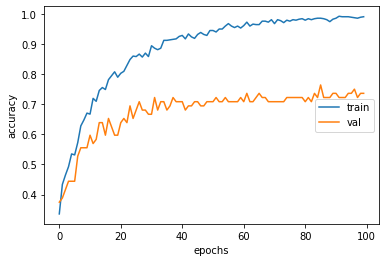

In [92]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# 6. TRANSFER LEARNING

## RESNET50

In [21]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=resnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [22]:
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name, "-", layer.trainable)

In [23]:
model = Sequential()
model.add(res_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                        

In [24]:
optimizer = optimizers.Adam(learning_rate= 0.00001)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [25]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [14]:
history_res = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

2022-06-26 12:54:41.145824: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-06-26 12:54:45.960438: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


20/20 [==============================] - 25s 704ms/step - loss: 2.4695 - acc: 0.2822 - val_loss: 1.4059 - val_acc: 0.3194

Epoch 00001: val_loss improved from inf to 1.40593, saving model to ./chest_CT_SCAN-ResNet50.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
20/20 [==============================] - 11s 532ms/step - loss: 2.2179 - acc: 0.3638 - val_loss: 1.2706 - val_acc: 0.4028

Epoch 00002: val_loss improved from 1.40593 to 1.27063, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 3/100
20/20 [==============================] - 10s 516ms/step - loss: 1.9242 - acc: 0.3866 - val_loss: 1.1674 - val_acc: 0.4444

Epoch 00003: val_loss improved from 1.27063 to 1.16742, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 4/100
20/20 [==============================] - 10s 513ms/step - loss: 1.5521 - acc: 0.4861 - val_loss: 1.0785 - val_acc: 0.5000

Epoch 00004: val_loss improved from 1.16742 to 1.07848, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 5/100
20/20 [==============================] - 10s 511ms/step - loss: 1.6118 - acc: 0.4649 - val_loss: 1.0152 - val_acc: 0.5278

Epoch 00005: val_loss improved from 1.07848 to 1.01523, saving model to ./chest_CT_SCAN-ResNet50.hdf5
Epoch 6/100
20/20 [==============================] -

In [15]:
result = model.evaluate(test_generator)

10/10 [==============================] - 6s 606ms/step - loss: 0.3190 - acc: 0.8952


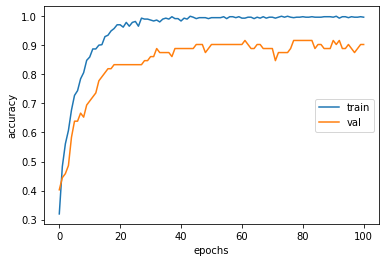

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## VGG16

In [26]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale=1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32',  rescale=1./255.)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [27]:
vgg_model = VGG16(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in vgg_model.layers:
    layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(vgg_model.layers):
#    print(i, layer.name, "-", layer.trainable)

58889256/58889256 [==============================] - 5s 0us/step


In [28]:
model = Sequential()
model.add(vgg_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 14718788 (56.15 MB)
Trainable params: 3076 (12.02 KB)
Non-trainable params: 14715712 (56.14 MB)
_________________________________________________________________


In [30]:
optimizer = optimizers.Adam(learning_rate= 0.00001)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [32]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-vgg16.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [21]:
history_vgg = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/100
20/20 [==============================] - 23s 707ms/step - loss: 1.6895 - acc: 0.2202 - val_loss: 1.6254 - val_acc: 0.1806

Epoch 00001: val_loss improved from inf to 1.62540, saving model to ./chest_CT_SCAN-/vgg16.hdf5
Epoch 2/100
20/20 [==============================] - 9s 442ms/step - loss: 1.6683 - acc: 0.2349 - val_loss: 1.5899 - val_acc: 0.1806

Epoch 00002: val_loss improved from 1.62540 to 1.58988, saving model to ./chest_CT_SCAN-/vgg16.hdf5
Epoch 3/100
20/20 [==============================] - 9s 426ms/step - loss: 1.6548 - acc: 0.2480 - val_loss: 1.5595 - val_acc: 0.1806

Epoch 00003: val_loss improved from 1.58988 to 1.55946, saving model to ./chest_CT_SCAN-/vgg16.hdf5
Epoch 4/100
20/20 [==============================] - 9s 423ms/step - loss: 1.6489 - acc: 0.2333 - val_loss: 1.5338 - val_acc: 0.1806

Epoch 00004: val_loss improved from 1.55946 to 1.53383, saving model to ./chest_CT_SCAN-/vgg16.hdf5
Epoch 5/100
20/20 [==============================] - 8s 414ms/step 

In [22]:
result = model.evaluate(test_generator)

10/10 [==============================] - 11s 1s/step - loss: 1.0257 - acc: 0.5079


## DenseNet201

In [33]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=densenet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [34]:
dense_model = DenseNet201(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in dense_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(dense_model.layers):
#    print(i, layer.name, "-", layer.trainable)


74836368/74836368 [==============================] - 6s 0us/step


In [35]:
model = Sequential()
model.add(dense_model)
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 batch_normalization_2 (Bat  (None, 1920)              7680      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 4)                 7684      
                                                                 
Total params: 18337348 (69.95 MB)
Trainable params: 6990084 (26.67 MB)
Non-trainable params: 11347264 (43.29 MB)
_________________________________________________________________


In [37]:
optimizer = optimizers.Adam(learning_rate= 0.00001)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [39]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-DenseNet201.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [40]:
history_dense = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - 28s 773ms/step - loss: 1.3360 - acc: 0.4290 - val_loss: 1.3543 - val_acc: 0.3194

Epoch 00001: val_loss improved from inf to 1.35428, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 2/200
20/20 [==============================] - 11s 525ms/step - loss: 0.7707 - acc: 0.7374 - val_loss: 1.2322 - val_acc: 0.4167

Epoch 00002: val_loss improved from 1.35428 to 1.23215, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 3/200
20/20 [==============================] - 11s 515ms/step - loss: 0.5573 - acc: 0.8450 - val_loss: 1.1418 - val_acc: 0.5139

Epoch 00003: val_loss improved from 1.23215 to 1.14177, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 4/200
20/20 [==============================] - 11s 543ms/step - loss: 0.4206 - acc: 0.9021 - val_loss: 1.0443 - val_acc: 0.5417

Epoch 00004: val_loss improved from 1.14177 to 1.04427, saving model to ./chest_CT_SCAN-DenseNet201.hdf5
Epoch 5/200
20/20 [=========================

In [41]:
result = model.evaluate(test_generator)

10/10 [==============================] - 7s 645ms/step - loss: 0.5469 - acc: 0.8190


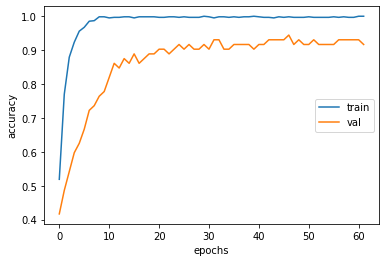

In [ ]:
plt.plot(history_dense.history['acc'], label = 'train',)
plt.plot(history_dense.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## EfficientNetB4

In [38]:
image_shape = (460,460,3)
N_CLASSES = 4
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=efficientnet.preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (460,460),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [39]:
efficient_model = EfficientNetB4(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in efficient_model.layers:
    if 'block7'not in layer.name and'top' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(efficient_model.layers):
#    print(i, layer.name, "-", layer.trainable)


71686520/71686520 [==============================] - 6s 0us/step


In [40]:
model = Sequential()
model.add(efficient_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 1792)              17673823  
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 1792)              0         
                                                                 
 batch_normalization_3 (Bat  (None, 1792)              7168      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 4)                 7172      
                                                                 
Total params: 17688163 (67.47 MB)
Trainable params: 5287160 (20.17 MB)
Non-trainable params: 12401003 (47.31 MB)
_________________________________________________________________


In [41]:
optimizer = optimizers.Adam(learning_rate= 0.00001)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [42]:
checkpointer = ModelCheckpoint(filepath='./chest_CT_SCAN-EfficientNet.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

In [47]:
history_efficient = model.fit(train_generator,
                    steps_per_epoch = 20,
                    epochs = 200,
                    verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping])

Epoch 1/200
20/20 [==============================] - 24s 657ms/step - loss: 1.8937 - acc: 0.2643 - val_loss: 1.4137 - val_acc: 0.3194

Epoch 00001: val_loss improved from inf to 1.41367, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 2/200
20/20 [==============================] - 10s 466ms/step - loss: 1.4198 - acc: 0.3866 - val_loss: 1.3631 - val_acc: 0.3611

Epoch 00002: val_loss improved from 1.41367 to 1.36310, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 3/200
20/20 [==============================] - 10s 491ms/step - loss: 1.0620 - acc: 0.5677 - val_loss: 1.3133 - val_acc: 0.3889

Epoch 00003: val_loss improved from 1.36310 to 1.31327, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 4/200
20/20 [==============================] - 10s 464ms/step - loss: 0.9396 - acc: 0.6232 - val_loss: 1.2599 - val_acc: 0.4167

Epoch 00004: val_loss improved from 1.31327 to 1.25986, saving model to ./chest_CT_SCAN-EfficientNet.hdf5
Epoch 5/200
20/20 [=====================

In [48]:
result = model.evaluate(test_generator)

10/10 [==============================] - 5s 457ms/step - loss: 0.4574 - acc: 0.8540


---

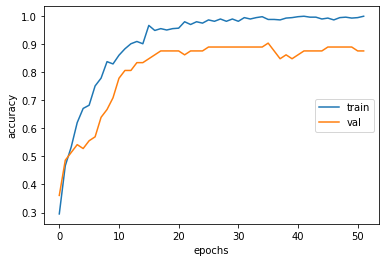

In [82]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# The Most three promised models are:
* ResNet50 **89.52 on test data,**
* DenseNet201 **88 on test data**
* EfficientNetB4 **90 on test data**